# Notes

### Dataset MMLU Computer Security:
* https://huggingface.co/datasets/cais/mmlu/viewer/computer_security/test

### Big Mistake in Prompt:
**Added the """ after a linebreak e.g.** <br>
Anwser: <br>
"""<br>
**Correct way:<br>**
Anwser:"""

## Cisco Pass exam
* https://learningnetwork.cisco.com/s/question/0D53i00000U2TO7CAN/what-is-the-pass-percentage-required-to-get-in-ccna-200301
* 825 / 1000 (82 %)
* Every (paid) exam takes 120 min and has about 120 Questions

## HELM  implementation: 
* Max_output tokens to restrict the possible outputs to the max number of answers possibilities
* Temperature = 0
* Joint strategy (all answer choices are presented at once)
* Short Introduction: The following are multiple choice questions (with answers) about computer security.
* (Paper: https://arxiv.org/pdf/2211.09110.pdf)

## HELM / Paper Imprreovements:
* Sampling --> std, mean min / max accuracy

# CCNA 201-301 - 5 Shot like HELM with Answer format: Answer: ABC or Answer: A <br>
### Oberservations Phi:
* Output of Phi-Model always empty, similiar config as mmlu (temp=0, max_output_token = 2), by increasing temp the result of Phi is better but still not close to the other models<br>
* Also have to increase the Max Output Tokens otherwise only \n as response
* Possible approach: Increasing temp and output_tokens, regex pattern that searchs for string in responses
### Oberservations Llama 2:
* LLama 2 results are much worse in comp. to single shot with Correct Answer: ['A', 'B'] and temp =0.7 and no limit to output tokens


## New 

* ~~Yi, Llama 1, Llama 2 (nicht uncensored), Mixtral, Phi-2 --> Für MMLU~~
* Change Answer to Letter (Frage: Exam Answer sind in HELM so, doch ändern?)
* ~~Prompt without whitespace --> extra ~~
* Ungeshuffeld vs HELM Grafik --> HELM vs unsere
* Shuffle (min-max) vs nicht shuffeln
* Dokumentieren --> Prompt, Changes Correct Answer Helm implementierung
* Folien für Präsentation --> Implementierung, Ergebnisse (MMLU ähnlich wie HELM) --> , mit mehr Tokens CCNA Paper (Questionsbank nicht veröffentlicht) --> Weg Cisco (350-701 SCOR), Vetgleich zum Paper
* Alles Dokumentieren
* **How many points to pass? --> Horizontale** 

In [1]:
from templates import *
import time
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
import pandas as pd
from langchain import PromptTemplate
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random
import warnings
import numpy as np
import json
warnings.filterwarnings('ignore')
#Set the output limit to inf
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


In [12]:
CCNA_200_301 = pd.read_parquet("../data/CCNA_200_301.parquet")

FileNotFoundError: [Errno 2] No such file or directory: '../data/CCNA_200_301.pkl'

In [11]:
# Angenommen, Ihr DataFrame heißt df und hat die Spalten 'choices' und 'answer'
probabilities = []
for idx, row in CCNA_201_301.iterrows():
    total_choices = len(row['choices'])
    correct_answers = len(row['answer'])
    
    # Wahrscheinlichkeit für eine richtige Antwort
    probability_one_correct = correct_answers / total_choices
    
    # Wahrscheinlichkeit für alle richtige Antworten
    if correct_answers > 1:
        probability_all_correct = (correct_answers / total_choices) * ((correct_answers - 1) / (total_choices - 1))
    else:
        probability_all_correct = probability_one_correct

    probabilities.append(probability_all_correct)

# Sume the probabilities list and divide by the number of questions
probability = sum(probabilities) / len(probabilities)

probability

NameError: name 'CCNA_201_301' is not defined

In [8]:
MODEL_PATH = { "Mixtral-8x-7b": "../models/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf",
               "Phi-2": "../models/phi-2.Q5_K_M.gguf",
               "Llama2-70b": "../models/llama-2-70b.Q5_K_M.gguf",
               "Yi-34b": "../models/yi-34b-200k.Q5_K_M.gguf",
               "Llama-65b": "../models/llama-65b.Q5_K_M.gguf",
              }

########### Set the model parameters here ############

#Parameter for changing the temperature of the model
TEMPERATURE = 0

#Parameter for max output tokens (for MMLU choose 1, since only Single choice)

MAX_OUTPUT_TOKENS = 2

########### Set the model parameters here ############


#Sampling rate determines how often a question is asked again if the answer format is wrong
MAX_SAMPLING_RATE = 5

#Set to 1 if you dont want to shuffle
NUM_OF_SHUFFLES = 5


########### Set the names for result / evaluation files here ############

#Set run name
RUN_NAME = "120_questions_5_Shot_201_301"

#Set output file name
OUTPUT_EVALUATION = "../results/120_questions_5_Shot_201_301/llm_5_Shot_201_301.pkl"

#Filename output evaluation detailed
OUTPUT_EVALUATION_DETAILED = "../results/120_questions_5_Shot_201_301/llm_prob_result_detailed_201_301_CCNA_5_Shot.pkl"

#Set filename of json file
OUTPUT_EVALUATION_JSON = "../results/120_questions_5_Shot_201_301/llm_prob_result_201_301_CCNA_5_Shot.json"

########### Set the names for result files here ############


########### Set the questionsbank here ############
#Set the questionsbank
QUESTIONS_BANK = "../data/201-301-CCNA.parquet" ##CCNA
#QUESTIONS_BANK = "../data/mmlu_Computer_Security.parquet" ##CCNA
HELM_RESULT = pd.read_pickle("../data/official_sec_mmlu_results.pkl")
########### Set the questionsbank here ############

########### Set the prompt template here ############
PROMPT_TEMPLATE = CCNA_5_SHOT_TEMPLATE
########### Set the prompt template here ############

In [4]:
# #Save the parameters as a JSON file
# parameters = {
#     "RUN_NAME": RUN_NAME,  # Ersetzen Sie durch den tatsächlichen Wert
#     "QUESTION_BANK": QUESTIONS_BANK,  # Ersetzen Sie durch den tatsächlichen Wert
#     "MAX_SAMPLING_RATE": MAX_SAMPLING_RATE,  # Ersetzen Sie durch den tatsächlichen Wert
#     "NUM_OF_SHUFFLES": NUM_OF_SHUFFLES,  # Ersetzen Sie durch den tatsächlichen Wert
#     "FEW_SHOT_TEMPLATE": PROMPT_TEMPLATE,  # Ersetzen Sie durch den tatsächlichen Wert
#     "TEMPERATURE": TEMPERATURE,  # Ersetzen Sie durch den tatsächlichen Wert
#     "MAX_TOKENS": MAX_OUTPUT_TOKENS  # Ersetzen Sie durch den tatsächlichen Wert
# }

# # Speichern Sie das Wörterbuch als JSON-Datei
# with open(OUTPUT_EVALUATION_JSON, 'w') as f:
#     json.dump(parameters, f)

In [9]:
def extract_answer(answer):
    """Extracts the correct answers from the provided answer string.

    Args:
        answer: The answer string to extract the correct answers from.

    Returns:
        A list of correct answers (e.g., ['A', 'B']) if found, otherwise None. 
    """
    #print(repr(answer))
    answer = re.sub(r'[\s\n.,]', '', answer)
    pattern = re.compile(r'^[A-Z,]*$')
    #print(answer)
    if re.match(pattern, answer):
        if ',' in answer:
            return None
        else:
            return list(answer)
    else:
        return None
    
def compare_answers(answerLLM, answer_exam):
    """Compares the extracted correct answers with the answers in answer_exam.

    Keyword arguments:
    answerLLM -- the list of answers extracted from the LLM answer
    answer_exam -- list of answers from the exam
    """
    # Convert answer_exam_list from letters to numbers
    answerLLM = [ord(answer) - 65 for answer in answerLLM]

    # Get number of correct answers in the exam
    num_of_correct_exam_answers = len(answer_exam)

    # Convert both lists to sets for efficient comparison
    answer_LLM_set = set(answerLLM)
    answer_exam_set = set(answer_exam)

    # Calculate the count of matching answers
    number_of_correct_llm_answers = len(answer_LLM_set.intersection(answer_exam_set))

    # Check if the number of answers given by the LLM is greater than the number of correct answers
    too_many_answ_given = False
    if len(answer_LLM_set) > num_of_correct_exam_answers:
        too_many_answ_given = True

    # Return a dictionary with the matching count and the number of correct answers
    return number_of_correct_llm_answers, too_many_answ_given

def format_choices_for_llm(choices):
    #Define the letters for the choices
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    # Erstellen Sie den formatierten String
    formatted_choices = '\n'.join(f'{letters[i]}. {choice}' for i, choice in enumerate(choices))
    
    return formatted_choices

def evaluation_sampling(llm_answer, exam_Answers, num_of_correct_answer):
    """Analyse the answer given by the LLM and compare it with the exam answers.

    Keyword arguments:
    llm_answer -- the answer string given by the LLM
    exam_Answers -- the list of answers from the exam
    """

    answerLLM = extract_answer(llm_answer)
    if answerLLM is not None:
        num_of_correct_llm_Answers, too_many_answ = compare_answers(answerLLM, exam_Answers)
        if num_of_correct_llm_Answers == num_of_correct_answer and too_many_answ == False:
            answered_correctly = True
        else:
            answered_correctly = False 
        return num_of_correct_llm_Answers, answerLLM, too_many_answ, answered_correctly
    else:
         return -1


def evaluation(llm_output_dataframe):

    # Compute the number of total questions for each model
    number_of_questions = llm_output_dataframe.groupby('Model')['QuestionIndex'].count()
    
    #Number of fully correct answers given by the LLM
    correctly_answered = llm_output_dataframe.groupby('Model')['Answered_Correctly'].sum()

    #Number of incorrect answers given by the LLM
    incorrectly_answered = number_of_questions - correctly_answered

    #Amount of correct answers in the exam
    amount_correcct_exam_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectExamAnswers'].sum()

    #Amount of correct answers given by the LLM even if not fully correct
    amount_correcct_llm_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectLLMAnswers'].sum()
    
    #Calculation of Accuracy and Recall and f1 score
    accuracy = correctly_answered / number_of_questions
    accuracy_partial = amount_correcct_llm_answers / amount_correcct_exam_answers


    results_df = pd.DataFrame({
        'Number of Questions': number_of_questions,
        'Correctly Answered': correctly_answered,
        'Incorrectly Answered': incorrectly_answered,
        'Accuracy': accuracy,
        'Accuracy Partial': accuracy_partial,
    })

    results_df = results_df.reset_index()

    return results_df


def plot_evaluation_CCNA(evaluation_df, hline_accuracy=None, hline_partial=None, title=None):
    """
    Plots evaluation metrics from a DataFrame containing columns:
        - 'Model'
        - 'Accuracy Mean', 'Accuracy Min', 'Accuracy Max'
        - 'Accuracy Partial Mean', 'Accuracy Partial Min', 'Accuracy Partial Max'
    """

    # Define a list of colors for the models
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Define bar width
    bar_width = 0.5  # Increase bar width for thicker bars

    # --- Subplot 1: Accuracy ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[0].bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Mean'], bar_width, 
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Mean'] - evaluation_df.loc[i, 'Accuracy Min'])], [abs(evaluation_df.loc[i, 'Accuracy Max'] - evaluation_df.loc[i, 'Accuracy Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[0].set_ylabel('Accuracy (%)')
    axs[0].set_title('Accuracy Mean with Error Bars (Max and Min)', fontsize=12)
    axs[0].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[0].legend()
    axs[0].set_ylim([0, 1])
    axs[0].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[0].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Accuracy subplot
    if hline_accuracy is not None:
        axs[0].axhline(y=hline_accuracy, color='r', linestyle='--')

    # --- Subplot 2: Partial Accuracy ---
    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[1].bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Partial Mean'] - evaluation_df.loc[i, 'Accuracy Partial Min'])], [abs(evaluation_df.loc[i, 'Accuracy Partial Max'] - evaluation_df.loc[i, 'Accuracy Partial Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[1].set_ylabel('Accuracy Partial (%)')
    axs[1].set_title('Accuracy Partial Mean with Error Bars (Max and Min)', fontsize=12)
    axs[1].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[1].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[1].legend()
    axs[1].set_ylim([0, 1])
    axs[1].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[1].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Partial Accuracy subplot
    if hline_partial is not None:
        axs[1].axhline(y=hline_partial, color='r', linestyle='--')

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.show()

def calculate_model_statistics(df):
    """
    Calculates statistics for each model in the DataFrame.
    
    Args:
    df (DataFrame): Input DataFrame containing evaluation metrics for different models.
    
    Returns:
    DataFrame: New DataFrame containing calculated statistics for each model.
    """
    model_stats = []
    for model, group_df in df.groupby('Model'):
        model_stat = {
            'Model': model,
            'Accuracy Mean': group_df['Accuracy'].mean(),
            'Accuracy Max': group_df['Accuracy'].max(),
            'Accuracy Min': group_df['Accuracy'].min(),
            'Accuracy STD': group_df['Accuracy'].std(),
            'Accuracy Partial Mean': group_df['Accuracy Partial'].mean(),
            'Accuracy Partial Max': group_df['Accuracy Partial'].max(),
            'Accuracy Partial Min': group_df['Accuracy Partial'].min(),
            'Accuracy Partial STD': group_df['Accuracy Partial'].std()
        }
        model_stats.append(model_stat)
    
    return pd.DataFrame(model_stats)


def shuffle_choices_and_update_answer(choices, answer):
    # Erstellen Sie eine Liste von Indizes und mischen Sie sie
    indices = list(range(len(choices)))
    random.shuffle(indices)
    
    # Verwenden Sie die gemischten Indizes, um die Auswahlmöglichkeiten und die Antwort zu aktualisieren
    shuffled_choices = [choices[i] for i in indices]
    updated_answer = [indices.index(a) for a in answer]  # Entfernen Sie +1, um 0-basierte Indizes zu verwenden
    
    return shuffled_choices, updated_answer

def plot_evaluation_MMLU(llm_result_df, helm_result, df1_name, df2_name, title=None):
    """
    Plots evaluation metrics from two DataFrames containing columns:
        - 'Model'
        - 'Accuracy'
    """

    # Define colors for the models
    color_llm_result = 'b'
    color_helm_result = 'orange'

    # Define bar width and gap
    bar_width = 0.2  # Decrease bar width for side-by-side bars with a gap
    gap = 0.05  # Define gap between bars

    # Merge the two dataframes by column Model and create a new dataframe and rename the column Accuracy Mean to Accuracy Mean LLM and Accuracy to Accuracy HELM
    llm_result_df = pd.merge(llm_result_df, helm_result, on='Model', suffixes=('_LLM', '_HELM'))
    llm_result_df = llm_result_df.rename(columns={'Accuracy': 'Accuracy_HELM', 'Accuracy Mean': 'Accuracy_Mean_LLM'})

    display(llm_result_df)

    # Just one plot
    fig, ax = plt.subplots(figsize=(14, 6))

    for i, model in enumerate(llm_result_df['Model']):
        bars_llm = ax.bar(i - bar_width - gap / 2, llm_result_df.loc[i, 'Accuracy_Mean_LLM'], bar_width, color=color_llm_result)
        bars_helm = ax.bar(i + gap / 2, llm_result_df.loc[i, 'Accuracy_HELM'], bar_width, color=color_helm_result)

    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Accuracy Mean LLM vs. HELM', fontsize=12)
    ax.set_xticks([i for i in range(len(llm_result_df['Model']))])
    ax.set_xticklabels(llm_result_df['Model'], rotation=45, ha='right', fontsize=10)
    ax.legend([bars_llm, bars_helm], [df1_name, df2_name])
    ax.set_ylim([0, 1])
    ax.yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Accuracy subplot
    ax.axhline(y=probability, color='r', linestyle='--')

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.show()

In [10]:
valid_question_answer = False  
#Create a dataframe with the size of NUM_OF_SHUFFLES which contains the dataframe llm_exam_result
shuffled_evalutation_df = pd.DataFrame(columns=[ 'Number of Questions','Correctly Answered','Incorrectly Answered','Accuracy','Accuracy Partial'])

questions  = pd.read_parquet(QUESTIONS_BANK)

#Randomly take 120 questions
questions = questions.sample(n=120)

#Take the first 20 questions
#questions = questions.head(20)

#questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
prompt_template = PromptTemplate.from_template(PROMPT_TEMPLATE)

#Iterate over each model definied in the MODEL_PATH dictionary
for model, model_path in MODEL_PATH.items():
     #Load the model wiht LLamaCpp
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=128,
        n_batch=1024,
        n_ctx=1100,
        temperature=TEMPERATURE,
        top_p=1,
        max_tokens = MAX_OUTPUT_TOKENS,
        #callback_manager=callback_manager,
        verbose=False,  # Verbose is required to pass to the callback manager
    )
    chain = prompt_template | llm
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
        #Iterate over each question in the question dataframe
        
        #Start the timer
        start_time = time.time()
        for index_question, row in questions.iterrows():
            question = row['question']
            choices = row['choices']
            answers = row['answer']
            num_of_correct_answer = len(answers)

            choices = format_choices_for_llm(choices)

            #Only if shuffle is enabled, shuffle the choices
            if shuffled_iteration > 0:
                choices, answers = shuffle_choices_and_update_answer(row['choices'], row['answer'])
                num_of_correct_answer = len(answers)
                choices = format_choices_for_llm(choices)
            #Empty the char_probabilities dictionary for each question
            char_probabilities = {}

            #Iterate over the maximum sampling rate
            for index_sampling in range(MAX_SAMPLING_RATE):
                # Invoke the chain with the question and choices              
                

                ########### Print the question and choices ############
                #print(f"Question: {question}")
                #print(choices)

                llm_answer = chain.invoke({"Exam_Question" : row['question'], "Exam_Choices" : choices})     
                #print(llm_answer)       
                # Check if the answer is in the expected format
                if extract_answer(llm_answer) is not None:
                    # Extract the correct answers from the LLM answer and analyse the answer
                    num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly = evaluation_sampling(llm_answer, answers, num_of_correct_answer)
                    #Save the current sampling index -- How of the question has been asked until the answer was in the correct format
                    sample_Index = index_sampling
                    valid_question_answer = True
                    break
            
            #Depending on the result of the answer, add the result to the dataframe
            if not valid_question_answer:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [-1], "NumberOfCorrectLLMAnswers": [0], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [-1], "LLM_Answer": [llm_answer], "Exam_Answers": [answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
            else:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [sample_Index], "NumberOfCorrectLLMAnswers": [num_of_correct_llm_answer], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [num_of_correct_llm_answer/num_of_correct_answer], "LLM_Answer": [answerLLm], "Exam_Answers": [answers], "Answered_Correctly" : [answered_correctly], "Too_Many_answers": [too_many_answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
                valid_question_answer = False
        answered_correctly = False
        #Concat the the dataframe returned by evaulation to one dataframe
        display(llm_exam_result)
        llm_exam_result.to_pickle(f"../data/120_questions_{model}_shuffled_{shuffled_iteration}_mmlu.pkl")
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
        display(shuffled_evalutation_df)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Time taken:", elapsed_time, "seconds")


#plot_evaluation(shuffled_evalutation_df)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)
#plot_evaluation_MMLU(model_statistics, HELM_RESULT, "Own Approach", "HELM", title="Own Approach vs. HELM Official")
shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
model_statistics.to_pickle(OUTPUT_EVALUATION)


llama_model_loader: loaded meta data with 26 key-value pairs and 995 tensors from ../models/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mixtral-8x7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:    

Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Mixtral-8x-7b           127             0                         0   
1    Mixtral-8x-7b            48             0                         2   
2    Mixtral-8x-7b           201             0                         0   
3    Mixtral-8x-7b            75             0                         0   
4    Mixtral-8x-7b            34            -1                         0   
..             ...           ...           ...                       ...   
115  Mixtral-8x-7b           114             0                         1   
116  Mixtral-8x-7b           137             0                         0   
117  Mixtral-8x-7b           157             0                         2   
118  Mixtral-8x-7b            43             0                         2   
119  Mixtral-8x-7b             0             0                         2   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000         []          [1]   
1                            2  1.000000     [A, D]       [0, 3]   
2                            1  0.000000        [A]          [3]   
3                            1  0.000000        [C]          [0]   
4                            1 -1.000000         00          [1]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [A]          [0]   
116                          1  0.000000         []          [2]   
117                          3  0.666667  [B, C, E]    [1, 3, 4]   
118                          2  1.000000     [A, E]       [0, 4]   
119                          2  1.000000     [A, D]       [0, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                 True            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118               True            False  
119               True            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b

Time taken: 48.13739562034607 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Mixtral-8x-7b           127             0                         0   
1    Mixtral-8x-7b            48             0                         1   
2    Mixtral-8x-7b           201             0                         1   
3    Mixtral-8x-7b            75             0                         0   
4    Mixtral-8x-7b            34            -1                         0   
..             ...           ...           ...                       ...   
115  Mixtral-8x-7b           114             0                         1   
116  Mixtral-8x-7b           137             0                         0   
117  Mixtral-8x-7b           157             0                         2   
118  Mixtral-8x-7b            43             0                         2   
119  Mixtral-8x-7b             0             0                         2   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000        [B]          [3]   
1                            2  0.500000     [A, D]       [2, 0]   
2                            1  1.000000        [A]          [0]   
3                            1  0.000000         []          [3]   
4                            1 -1.000000         00          [0]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [B]          [1]   
116                          1  0.000000         []          [3]   
117                          3  0.666667  [A, C, D]    [5, 0, 3]   
118                          2  1.000000     [A, D]       [0, 3]   
119                          2  1.000000     [B, D]       [1, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                 True            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118               True            False  
119               True            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   
1                 120                 60                   60       0.5   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b  
1         0.553333  Mixtral-8x-7b

Time taken: 50.59797239303589 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Mixtral-8x-7b           127             0                         0   
1    Mixtral-8x-7b            48             0                         0   
2    Mixtral-8x-7b           201             0                         0   
3    Mixtral-8x-7b            75             0                         0   
4    Mixtral-8x-7b            34            -1                         0   
..             ...           ...           ...                       ...   
115  Mixtral-8x-7b           114             0                         1   
116  Mixtral-8x-7b           137             0                         0   
117  Mixtral-8x-7b           157             0                         1   
118  Mixtral-8x-7b            43             0                         2   
119  Mixtral-8x-7b             0             0                         2   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000         []          [1]   
1                            2  0.000000     [A, D]       [2, 4]   
2                            1  0.000000        [A]          [1]   
3                            1  0.000000        [D]          [0]   
4                            1 -1.000000         00          [2]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [D]          [3]   
116                          1  0.000000         []          [1]   
117                          3  0.333333        [A]    [1, 0, 2]   
118                          2  1.000000     [B, C]       [2, 1]   
119                          2  1.000000     [B, D]       [3, 1]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118               True            False  
119               True            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   
1                 120                 60                   60       0.5   
2                 120                 56                   64  0.466667   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b  
1         0.553333  Mixtral-8x-7b  
2         0.533333  Mixtral-8x-7b

Time taken: 49.32000160217285 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Mixtral-8x-7b           127             0                         0   
1    Mixtral-8x-7b            48             0                         1   
2    Mixtral-8x-7b           201             0                         0   
3    Mixtral-8x-7b            75             0                         0   
4    Mixtral-8x-7b            34            -1                         0   
..             ...           ...           ...                       ...   
115  Mixtral-8x-7b           114             0                         1   
116  Mixtral-8x-7b           137             0                         1   
117  Mixtral-8x-7b           157             0                         1   
118  Mixtral-8x-7b            43             0                         1   
119  Mixtral-8x-7b             0             0                         1   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000        [B]          [3]   
1                            2  0.500000     [A, D]       [3, 4]   
2                            1  0.000000        [A]          [1]   
3                            1  0.000000        [C]          [3]   
4                            1 -1.000000         00          [3]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [D]          [3]   
116                          1  1.000000        [D]          [3]   
117                          3  0.333333        [A]    [0, 2, 3]   
118                          2  0.500000        [C]       [2, 3]   
119                          2  0.500000     [A, D]       [4, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116               True            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   
1                 120                 60                   60       0.5   
2                 120                 56                   64  0.466667   
3                 120                 47                   73  0.391667   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b  
1         0.553333  Mixtral-8x-7b  
2         0.533333  Mixtral-8x-7b  
3             0.46  Mixtral-8x-7b

Time taken: 48.049078941345215 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Mixtral-8x-7b           127             0                         0   
1    Mixtral-8x-7b            48             0                         1   
2    Mixtral-8x-7b           201             0                         0   
3    Mixtral-8x-7b            75             0                         0   
4    Mixtral-8x-7b            34            -1                         0   
..             ...           ...           ...                       ...   
115  Mixtral-8x-7b           114             0                         1   
116  Mixtral-8x-7b           137             0                         0   
117  Mixtral-8x-7b           157             0                         2   
118  Mixtral-8x-7b            43             0                         2   
119  Mixtral-8x-7b             0             0                         2   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000        [B]          [2]   
1                            2  0.500000     [A, D]       [0, 4]   
2                            1  0.000000        [A]          [2]   
3                            1  0.000000         []          [3]   
4                            1 -1.000000         00          [1]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [B]          [1]   
116                          1  0.000000         []          [3]   
117                          3  0.666667  [A, D, F]    [5, 4, 3]   
118                          2  1.000000     [C, D]       [3, 2]   
119                          2  1.000000     [A, C]       [0, 2]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118               True            False  
119               True            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   
1                 120                 60                   60       0.5   
2                 120                 56                   64  0.466667   
3                 120                 47                   73  0.391667   
4                 120                 57                   63     0.475   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b  
1         0.553333  Mixtral-8x-7b  
2         0.533333  Mixtral-8x-7b  
3             0.46  Mixtral-8x-7b  
4             0.56  Mixtral-8x-7b

Time taken: 47.2200710773468 seconds


llama_model_loader: loaded meta data with 20 key-value pairs and 325 tensors from ../models/phi-2.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi2
llama_model_loader: - kv   1:                               general.name str              = Phi2
llama_model_loader: - kv   2:                        phi2.context_length u32              = 2048
llama_model_loader: - kv   3:                      phi2.embedding_length u32              = 2560
llama_model_loader: - kv   4:                   phi2.feed_forward_length u32              = 10240
llama_model_loader: - kv   5:                           phi2.block_count u32              = 32
llama_model_loader: - kv   6:                  phi2.attention.head_count u32              = 32
llama_model_loader: - kv   7:               phi2.attention.head_count_kv u32             

Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Phi-2           127             0                         0   
1    Phi-2            48             0                         0   
2    Phi-2           201             0                         0   
3    Phi-2            75             0                         0   
4    Phi-2            34             0                         0   
..     ...           ...           ...                       ...   
115  Phi-2           114             0                         0   
116  Phi-2           137             0                         0   
117  Phi-2           157             0                         0   
118  Phi-2            43             0                         0   
119  Phi-2             0             0                         0   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0         []          [1]   
1                            2    0.0         []       [0, 3]   
2                            1    0.0         []          [3]   
3                            1    0.0         []          [0]   
4                            1    0.0         []          [1]   
..                         ...    ...        ...          ...   
115                          1    0.0         []          [0]   
116                          1    0.0         []          [2]   
117                          3    0.0         []    [1, 3, 4]   
118                          2    0.0         []       [0, 4]   
119                          2    0.0         []       [0, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                False            False  
..                 ...              ...  
115              False            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   
1                 120                 60                   60       0.5   
2                 120                 56                   64  0.466667   
3                 120                 47                   73  0.391667   
4                 120                 57                   63     0.475   
5                 120                  0                  120       0.0   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b  
1         0.553333  Mixtral-8x-7b  
2         0.533333  Mixtral-8x-7b  
3             0.46  Mixtral-8x-7b  
4             0.56  Mixtral-8x-7b  
5              0.0          Phi-2

Time taken: 6.154097318649292 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Phi-2           127             0                         0   
1    Phi-2            48             0                         0   
2    Phi-2           201             0                         0   
3    Phi-2            75             0                         0   
4    Phi-2            34             0                         0   
..     ...           ...           ...                       ...   
115  Phi-2           114             0                         0   
116  Phi-2           137             0                         0   
117  Phi-2           157             0                         0   
118  Phi-2            43             0                         0   
119  Phi-2             0             0                         0   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0         []          [0]   
1                            2    0.0         []       [4, 3]   
2                            1    0.0         []          [0]   
3                            1    0.0         []          [3]   
4                            1    0.0         []          [1]   
..                         ...    ...        ...          ...   
115                          1    0.0         []          [3]   
116                          1    0.0         []          [1]   
117                          3    0.0         []    [1, 5, 3]   
118                          2    0.0         []       [3, 4]   
119                          2    0.0         []       [2, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                False            False  
..                 ...              ...  
115              False            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   
1                 120                 60                   60       0.5   
2                 120                 56                   64  0.466667   
3                 120                 47                   73  0.391667   
4                 120                 57                   63     0.475   
5                 120                  0                  120       0.0   
6                 120                  0                  120       0.0   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b  
1         0.553333  Mixtral-8x-7b  
2         0.533333  Mixtral-8x-7b  
3             0.46  Mixtral-8x-7b  
4             0.56  Mixtral-8x-7b  
5              0.0          Phi-2  
6              0.0          Phi-2

Time taken: 6.962631702423096 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Phi-2           127             0                         0   
1    Phi-2            48             0                         0   
2    Phi-2           201             0                         0   
3    Phi-2            75             0                         0   
4    Phi-2            34             0                         0   
..     ...           ...           ...                       ...   
115  Phi-2           114             0                         0   
116  Phi-2           137             0                         0   
117  Phi-2           157             0                         0   
118  Phi-2            43             0                         0   
119  Phi-2             0             0                         0   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0         []          [2]   
1                            2    0.0         []       [3, 1]   
2                            1    0.0         []          [1]   
3                            1    0.0         []          [1]   
4                            1    0.0         []          [3]   
..                         ...    ...        ...          ...   
115                          1    0.0         []          [2]   
116                          1    0.0         []          [2]   
117                          3    0.0         []    [1, 2, 0]   
118                          2    0.0         []       [0, 2]   
119                          2    0.0         []       [4, 0]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                False            False  
..                 ...              ...  
115              False            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   
1                 120                 60                   60       0.5   
2                 120                 56                   64  0.466667   
3                 120                 47                   73  0.391667   
4                 120                 57                   63     0.475   
5                 120                  0                  120       0.0   
6                 120                  0                  120       0.0   
7                 120                  0                  120       0.0   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b  
1         0.553333  Mixtral-8x-7b  
2         0.533333  Mixtral-8x-7b  
3             0.46  Mixtral-8x-7b  
4             0.56  Mixtral-8x-7b  
5              0.0          Phi-2  
6              0.0          Phi-2  
7              0.0          Phi-2

Time taken: 6.728620767593384 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Phi-2           127             0                         0   
1    Phi-2            48             0                         0   
2    Phi-2           201             0                         0   
3    Phi-2            75             0                         0   
4    Phi-2            34             0                         0   
..     ...           ...           ...                       ...   
115  Phi-2           114             0                         0   
116  Phi-2           137             0                         0   
117  Phi-2           157             0                         0   
118  Phi-2            43             0                         0   
119  Phi-2             0             0                         0   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0         []          [3]   
1                            2    0.0         []       [0, 1]   
2                            1    0.0         []          [1]   
3                            1    0.0         []          [0]   
4                            1    0.0         []          [1]   
..                         ...    ...        ...          ...   
115                          1    0.0         []          [3]   
116                          1    0.0         []          [3]   
117                          3    0.0         []    [2, 1, 5]   
118                          2    0.0         []       [3, 2]   
119                          2    0.0         []       [2, 4]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                False            False  
..                 ...              ...  
115              False            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   
1                 120                 60                   60       0.5   
2                 120                 56                   64  0.466667   
3                 120                 47                   73  0.391667   
4                 120                 57                   63     0.475   
5                 120                  0                  120       0.0   
6                 120                  0                  120       0.0   
7                 120                  0                  120       0.0   
8                 120                  0                  120       0.0   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b  
1         0.553333  Mixtral-8x-7b  
2         0.533333  Mixtral-8x-7b  
3             0.46  Mixtral-8x-7b  
4             0.56  Mixtral-8x-7b  
5              0.0          Phi-2  
6              0.0          Phi-2  
7              0.0          Phi-2  
8              0.0          Phi-2

Time taken: 7.054743051528931 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Phi-2           127             0                         0   
1    Phi-2            48             0                         0   
2    Phi-2           201             0                         0   
3    Phi-2            75             0                         0   
4    Phi-2            34             0                         0   
..     ...           ...           ...                       ...   
115  Phi-2           114             0                         0   
116  Phi-2           137             0                         0   
117  Phi-2           157             0                         0   
118  Phi-2            43             0                         0   
119  Phi-2             0             0                         0   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0         []          [2]   
1                            2    0.0         []       [1, 2]   
2                            1    0.0         []          [3]   
3                            1    0.0         []          [1]   
4                            1    0.0         []          [1]   
..                         ...    ...        ...          ...   
115                          1    0.0         []          [1]   
116                          1    0.0         []          [2]   
117                          3    0.0         []    [4, 2, 3]   
118                          2    0.0         []       [3, 2]   
119                          2    0.0         []       [1, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                False            False  
..                 ...              ...  
115              False            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                 120                 67                   53  0.558333   
1                 120                 60                   60       0.5   
2                 120                 56                   64  0.466667   
3                 120                 47                   73  0.391667   
4                 120                 57                   63     0.475   
5                 120                  0                  120       0.0   
6                 120                  0                  120       0.0   
7                 120                  0                  120       0.0   
8                 120                  0                  120       0.0   
9                 120                  0                  120       0.0   

  Accuracy Partial          Model  
0         0.606667  Mixtral-8x-7b  
1         0.553333  Mixtral-8x-7b  
2         0.533333  Mixtral-8x-7b  
3             0.46  Mixtral-8x-7b  
4             0.56  Mixtral-8x-7b  
5              0.0          Phi-2  
6              0.0          Phi-2  
7              0.0          Phi-2  
8              0.0          Phi-2  
9              0.0          Phi-2

Time taken: 6.594112396240234 seconds


llama_model_loader: loaded meta data with 19 key-value pairs and 723 tensors from ../models/llama-2-70b.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 8192
llama_model_loader: - kv   4:                          llama.block_count u32              = 80
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 28672
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_count u32          

Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama2-70b           127             0                         1   
1    Llama2-70b            48             0                         2   
2    Llama2-70b           201             0                         0   
3    Llama2-70b            75             0                         0   
4    Llama2-70b            34             1                         1   
..          ...           ...           ...                       ...   
115  Llama2-70b           114             0                         1   
116  Llama2-70b           137             0                         0   
117  Llama2-70b           157             0                         2   
118  Llama2-70b            43             0                         1   
119  Llama2-70b             0             0                         2   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  1.000000        [B]          [1]   
1                            2  1.000000     [A, D]       [0, 3]   
2                            1  0.000000        [A]          [3]   
3                            1  0.000000        [D]          [0]   
4                            1  1.000000        [B]          [1]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [A]          [0]   
116                          1  0.000000        [D]          [2]   
117                          3  0.666667  [B, C, E]    [1, 3, 4]   
118                          2  0.500000     [A, D]       [0, 4]   
119                          2  1.000000     [A, D]       [0, 3]   

    Answered_Correctly Too_Many_answers  
0                 True            False  
1                 True            False  
2                False            False  
3                False            False  
4                 True            False  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118              False            False  
119               True            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b

Time taken: 58.1743426322937 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama2-70b           127             0                         1   
1    Llama2-70b            48             0                         2   
2    Llama2-70b           201             0                         0   
3    Llama2-70b            75             0                         0   
4    Llama2-70b            34            -1                         0   
..          ...           ...           ...                       ...   
115  Llama2-70b           114             0                         1   
116  Llama2-70b           137             0                         0   
117  Llama2-70b           157             0                         1   
118  Llama2-70b            43             0                         2   
119  Llama2-70b             0             0                         2   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  1.000000        [D]          [3]   
1                            2  1.000000     [A, D]       [3, 0]   
2                            1  0.000000        [A]          [3]   
3                            1  0.000000        [D]          [1]   
4                            1 -1.000000         00          [0]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [A]          [0]   
116                          1  0.000000        [C]          [1]   
117                          3  0.333333  [B, C, E]    [3, 0, 4]   
118                          2  1.000000     [A, D]       [0, 3]   
119                          2  1.000000     [A, C]       [2, 0]   

    Answered_Correctly Too_Many_answers  
0                 True            False  
1                 True            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118               True            False  
119               True            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b

Time taken: 58.79897093772888 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama2-70b           127             0                         1   
1    Llama2-70b            48             0                         1   
2    Llama2-70b           201             0                         0   
3    Llama2-70b            75             0                         0   
4    Llama2-70b            34            -1                         0   
..          ...           ...           ...                       ...   
115  Llama2-70b           114             0                         1   
116  Llama2-70b           137             0                         0   
117  Llama2-70b           157             0                         1   
118  Llama2-70b            43             0                         2   
119  Llama2-70b             0             0                         2   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  1.000000        [A]          [0]   
1                            2  0.500000     [A, D]       [4, 3]   
2                            1  0.000000        [A]          [3]   
3                            1  0.000000        [C]          [1]   
4                            1 -1.000000         00          [1]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [C]          [2]   
116                          1  0.000000        [B]          [0]   
117                          3  0.333333  [A, C, F]    [0, 4, 1]   
118                          2  1.000000     [B, E]       [4, 1]   
119                          2  1.000000     [B, C]       [2, 1]   

    Answered_Correctly Too_Many_answers  
0                 True            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118               True            False  
119               True            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b

Time taken: 58.2478449344635 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama2-70b           127             0                         0   
1    Llama2-70b            48             0                         1   
2    Llama2-70b           201             0                         0   
3    Llama2-70b            75             0                         0   
4    Llama2-70b            34            -1                         0   
..          ...           ...           ...                       ...   
115  Llama2-70b           114             0                         1   
116  Llama2-70b           137             0                         0   
117  Llama2-70b           157             0                         1   
118  Llama2-70b            43             0                         1   
119  Llama2-70b             0             0                         1   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000        [B]          [2]   
1                            2  0.500000     [A, D]       [3, 2]   
2                            1  0.000000        [A]          [2]   
3                            1  0.000000        [D]          [0]   
4                            1 -1.000000         00          [4]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [A]          [0]   
116                          1  0.000000        [B]          [2]   
117                          3  0.333333  [A, C, E]    [5, 3, 4]   
118                          2  0.500000     [D, E]       [3, 0]   
119                          2  0.500000     [A, E]       [2, 4]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b

Time taken: 59.530632972717285 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama2-70b           127             0                         1   
1    Llama2-70b            48             0                         1   
2    Llama2-70b           201             0                         0   
3    Llama2-70b            75             0                         0   
4    Llama2-70b            34            -1                         0   
..          ...           ...           ...                       ...   
115  Llama2-70b           114             0                         1   
116  Llama2-70b           137             0                         0   
117  Llama2-70b           157             0                         2   
118  Llama2-70b            43             0                         2   
119  Llama2-70b             0             0                         1   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  1.000000        [C]          [2]   
1                            2  0.500000     [A, D]       [4, 0]   
2                            1  0.000000        [D]          [1]   
3                            1  0.000000        [C]          [3]   
4                            1 -1.000000         00          [2]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [A]          [0]   
116                          1  0.000000        [D]          [1]   
117                          3  0.666667  [B, C, E]    [1, 3, 4]   
118                          2  1.000000     [A, D]       [0, 3]   
119                          2  0.500000     [A, D]       [0, 2]   

    Answered_Correctly Too_Many_answers  
0                 True            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118               True            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b

Time taken: 59.2686824798584 seconds


llama_model_loader: loaded meta data with 22 key-value pairs and 543 tensors from ../models/yi-34b-200k.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = 01-ai_yi-34b-200k
llama_model_loader: - kv   2:                       llama.context_length u32              = 200000
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 7168
llama_model_loader: - kv   4:                          llama.block_count u32              = 60
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 20480
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head

Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Yi-34b           127             0                         0   
1    Yi-34b            48             0                         0   
2    Yi-34b           201             0                         0   
3    Yi-34b            75             0                         0   
4    Yi-34b            34             0                         1   
..      ...           ...           ...                       ...   
115  Yi-34b           114             0                         0   
116  Yi-34b           137             0                         0   
117  Yi-34b           157            -1                         0   
118  Yi-34b            43             0                         0   
119  Yi-34b             0             0                         0   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0         []          [1]   
1                            2    0.0         []       [0, 3]   
2                            1    0.0         []          [3]   
3                            1    0.0         []          [0]   
4                            1    1.0        [B]          [1]   
..                         ...    ...        ...          ...   
115                          1    0.0         []          [0]   
116                          1    0.0         []          [2]   
117                          3   -1.0        1BD    [1, 3, 4]   
118                          2    0.0         []       [0, 4]   
119                          2    0.0         []       [0, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                 True            False  
..                 ...              ...  
115              False            False  
116              False            False  
117                NaN              NaN  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b

Time taken: 31.960474967956543 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Yi-34b           127             0                         0   
1    Yi-34b            48             0                         0   
2    Yi-34b           201             0                         0   
3    Yi-34b            75             0                         0   
4    Yi-34b            34            -1                         0   
..      ...           ...           ...                       ...   
115  Yi-34b           114             0                         0   
116  Yi-34b           137             0                         0   
117  Yi-34b           157            -1                         0   
118  Yi-34b            43             0                         0   
119  Yi-34b             0             0                         0   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0        [B]          [3]   
1                            2    0.0         []       [3, 4]   
2                            1    0.0         []          [3]   
3                            1    0.0         []          [0]   
4                            1   -1.0        1\n          [0]   
..                         ...    ...        ...          ...   
115                          1    0.0         []          [1]   
116                          1    0.0         []          [3]   
117                          3   -1.0         12    [1, 0, 2]   
118                          2    0.0         []       [1, 3]   
119                          2    0.0         []       [4, 0]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115              False            False  
116              False            False  
117                NaN              NaN  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   
16                 120                  4                  116  0.033333   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b  
16             0.04         Yi-34b

Time taken: 33.20780324935913 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Yi-34b           127             0                         0   
1    Yi-34b            48             0                         0   
2    Yi-34b           201             0                         0   
3    Yi-34b            75             0                         0   
4    Yi-34b            34             0                         0   
..      ...           ...           ...                       ...   
115  Yi-34b           114             0                         0   
116  Yi-34b           137             0                         0   
117  Yi-34b           157             0                         0   
118  Yi-34b            43             0                         0   
119  Yi-34b             0             0                         0   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0        [B]          [0]   
1                            2    0.0         []       [1, 4]   
2                            1    0.0         []          [3]   
3                            1    0.0        [D]          [1]   
4                            1    0.0         []          [1]   
..                         ...    ...        ...          ...   
115                          1    0.0         []          [1]   
116                          1    0.0         []          [2]   
117                          3    0.0         []    [4, 3, 5]   
118                          2    0.0         []       [2, 4]   
119                          2    0.0         []       [0, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                False            False  
..                 ...              ...  
115              False            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   
16                 120                  4                  116  0.033333   
17                 120                  9                  111     0.075   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b  
16             0.04         Yi-34b  
17         0.073333         Yi-34b

Time taken: 31.851651430130005 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Yi-34b           127             0                         0   
1    Yi-34b            48             0                         0   
2    Yi-34b           201             0                         0   
3    Yi-34b            75             0                         0   
4    Yi-34b            34             0                         0   
..      ...           ...           ...                       ...   
115  Yi-34b           114             0                         0   
116  Yi-34b           137             0                         0   
117  Yi-34b           157            -1                         0   
118  Yi-34b            43             0                         2   
119  Yi-34b             0             0                         0   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0         []          [2]   
1                            2    0.0         []       [4, 2]   
2                            1    0.0         []          [3]   
3                            1    0.0         []          [2]   
4                            1    0.0         []          [2]   
..                         ...    ...        ...          ...   
115                          1    0.0         []          [1]   
116                          1    0.0         []          [0]   
117                          3   -1.0         12    [1, 5, 2]   
118                          2    1.0     [B, D]       [1, 3]   
119                          2    0.0         []       [3, 4]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                False            False  
..                 ...              ...  
115              False            False  
116              False            False  
117                NaN              NaN  
118               True            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   
16                 120                  4                  116  0.033333   
17                 120                  9                  111     0.075   
18                 120                  5                  115  0.041667   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b  
16             0.04         Yi-34b  
17         0.073333         Yi-34b  
18         0.046667         Yi-34b

Time taken: 32.0509135723114 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Yi-34b           127             0                         0   
1    Yi-34b            48             0                         2   
2    Yi-34b           201             0                         0   
3    Yi-34b            75             0                         0   
4    Yi-34b            34             0                         0   
..      ...           ...           ...                       ...   
115  Yi-34b           114             0                         0   
116  Yi-34b           137             0                         0   
117  Yi-34b           157             1                         1   
118  Yi-34b            43             0                         0   
119  Yi-34b             0             0                         0   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000         []          [1]   
1                            2  1.000000     [D, E]       [4, 3]   
2                            1  0.000000         []          [1]   
3                            1  0.000000         []          [3]   
4                            1  0.000000         []          [3]   
..                         ...       ...        ...          ...   
115                          1  0.000000         []          [2]   
116                          1  0.000000         []          [3]   
117                          3  0.333333        [B]    [5, 1, 3]   
118                          2  0.000000         []       [0, 2]   
119                          2  0.000000         []       [1, 0]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                 True            False  
2                False            False  
3                False            False  
4                False            False  
..                 ...              ...  
115              False            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   
16                 120                  4                  116  0.033333   
17                 120                  9                  111     0.075   
18                 120                  5                  115  0.041667   
19                 120                  7                  113  0.058333   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b  
16             0.04         Yi-34b  
17         0.073333         Yi-34b  
18         0.046667         Yi-34b  
19         0.066667         Yi-34b

Time taken: 32.34082841873169 seconds


llama_model_loader: loaded meta data with 19 key-value pairs and 723 tensors from ../models/llama-65b.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = meta-llama-65b
llama_model_loader: - kv   2:                       llama.context_length u32              = 2048
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 8192
llama_model_loader: - kv   4:                          llama.block_count u32              = 80
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 22016
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_count u32      

Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama-65b           127             0                         0   
1    Llama-65b            48             0                         2   
2    Llama-65b           201             0                         0   
3    Llama-65b            75             0                         0   
4    Llama-65b            34            -1                         0   
..         ...           ...           ...                       ...   
115  Llama-65b           114            -1                         0   
116  Llama-65b           137             0                         0   
117  Llama-65b           157             0                         3   
118  Llama-65b            43             0                         2   
119  Llama-65b             0             0                         1   

    NumberOfCorrectExamAnswers  Ratio LLM_Answer Exam_Answers  \
0                            1    0.0        [A]          [1]   
1                            2    1.0     [A, D]       [0, 3]   
2                            1    0.0         []          [3]   
3                            1    0.0        [C]          [0]   
4                            1   -1.0         00          [1]   
..                         ...    ...        ...          ...   
115                          1   -1.0        1\n          [0]   
116                          1    0.0        [D]          [2]   
117                          3    1.0  [B, D, E]    [1, 3, 4]   
118                          2    1.0     [A, E]       [0, 4]   
119                          2    0.5     [A, E]       [0, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                 True            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115                NaN              NaN  
116              False            False  
117               True            False  
118               True            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   
16                 120                  4                  116  0.033333   
17                 120                  9                  111     0.075   
18                 120                  5                  115  0.041667   
19                 120                  7                  113  0.058333   
20                 120                 50                   70  0.416667   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b  
16             0.04         Yi-34b  
17         0.073333         Yi-34b  
18         0.046667         Yi-34b  
19         0.066667         Yi-34b  
20         0.553333      Llama-65b

Time taken: 67.85136771202087 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama-65b           127             0                         0   
1    Llama-65b            48             0                         0   
2    Llama-65b           201             0                         0   
3    Llama-65b            75             0                         0   
4    Llama-65b            34            -1                         0   
..         ...           ...           ...                       ...   
115  Llama-65b           114             0                         1   
116  Llama-65b           137             0                         0   
117  Llama-65b           157             0                         2   
118  Llama-65b            43             0                         1   
119  Llama-65b             0             0                         1   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000        [D]          [2]   
1                            2  0.000000     [A, D]       [1, 2]   
2                            1  0.000000         []          [1]   
3                            1  0.000000        [C]          [3]   
4                            1 -1.000000         00          [4]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [C]          [2]   
116                          1  0.000000        [C]          [1]   
117                          3  0.666667  [B, C, D]    [3, 5, 2]   
118                          2  0.500000     [A, E]       [0, 2]   
119                          2  0.500000     [B, D]       [2, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   
16                 120                  4                  116  0.033333   
17                 120                  9                  111     0.075   
18                 120                  5                  115  0.041667   
19                 120                  7                  113  0.058333   
20                 120                 50                   70  0.416667   
21                 120                 45                   75     0.375   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b  
16             0.04         Yi-34b  
17         0.073333         Yi-34b  
18         0.046667         Yi-34b  
19         0.066667         Yi-34b  
20         0.553333      Llama-65b  
21         0.473333      Llama-65b

Time taken: 69.3340437412262 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama-65b           127             0                         0   
1    Llama-65b            48             0                         1   
2    Llama-65b           201             0                         0   
3    Llama-65b            75             0                         0   
4    Llama-65b            34            -1                         0   
..         ...           ...           ...                       ...   
115  Llama-65b           114             0                         1   
116  Llama-65b           137             0                         0   
117  Llama-65b           157             0                         2   
118  Llama-65b            43             0                         1   
119  Llama-65b             0             0                         0   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000        [D]          [2]   
1                            2  0.500000     [B, D]       [1, 2]   
2                            1  0.000000         []          [1]   
3                            1  0.000000        [A]          [2]   
4                            1 -1.000000         00          [1]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [C]          [2]   
116                          1  0.000000        [D]          [1]   
117                          3  0.666667  [B, D, F]    [1, 3, 2]   
118                          2  0.500000     [B, D]       [1, 0]   
119                          2  0.000000     [B, D]       [4, 0]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118              False            False  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   
16                 120                  4                  116  0.033333   
17                 120                  9                  111     0.075   
18                 120                  5                  115  0.041667   
19                 120                  7                  113  0.058333   
20                 120                 50                   70  0.416667   
21                 120                 45                   75     0.375   
22                 120                 54                   66      0.45   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b  
16             0.04         Yi-34b  
17         0.073333         Yi-34b  
18         0.046667         Yi-34b  
19         0.066667         Yi-34b  
20         0.553333      Llama-65b  
21         0.473333      Llama-65b  
22         0.526667      Llama-65b

Time taken: 68.61059141159058 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama-65b           127             0                         0   
1    Llama-65b            48             0                         0   
2    Llama-65b           201             0                         0   
3    Llama-65b            75             0                         0   
4    Llama-65b            34             0                         1   
..         ...           ...           ...                       ...   
115  Llama-65b           114             0                         1   
116  Llama-65b           137             0                         0   
117  Llama-65b           157             0                         1   
118  Llama-65b            43             0                         1   
119  Llama-65b             0             0                         2   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000        [B]          [3]   
1                            2  0.000000     [A, D]       [4, 2]   
2                            1  0.000000         []          [0]   
3                            1  0.000000        [D]          [2]   
4                            1  1.000000        [C]          [2]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [D]          [3]   
116                          1  0.000000        [D]          [0]   
117                          3  0.333333  [B, D, F]    [0, 3, 2]   
118                          2  0.500000  [C, D, E]       [2, 0]   
119                          2  1.000000     [B, D]       [1, 3]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                 True            False  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118              False             True  
119               True            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   
16                 120                  4                  116  0.033333   
17                 120                  9                  111     0.075   
18                 120                  5                  115  0.041667   
19                 120                  7                  113  0.058333   
20                 120                 50                   70  0.416667   
21                 120                 45                   75     0.375   
22                 120                 54                   66      0.45   
23                 120                 45                   75     0.375   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b  
16             0.04         Yi-34b  
17         0.073333         Yi-34b  
18         0.046667         Yi-34b  
19         0.066667         Yi-34b  
20         0.553333      Llama-65b  
21         0.473333      Llama-65b  
22         0.526667      Llama-65b  
23         0.473333      Llama-65b

Time taken: 69.38718771934509 seconds


Model QuestionIndex SamplingIndex NumberOfCorrectLLMAnswers  \
0    Llama-65b           127             0                         0   
1    Llama-65b            48             0                         1   
2    Llama-65b           201             0                         0   
3    Llama-65b            75             0                         0   
4    Llama-65b            34            -1                         0   
..         ...           ...           ...                       ...   
115  Llama-65b           114             0                         1   
116  Llama-65b           137             0                         0   
117  Llama-65b           157             0                         2   
118  Llama-65b            43             0                         2   
119  Llama-65b             0             0                         1   

    NumberOfCorrectExamAnswers     Ratio LLM_Answer Exam_Answers  \
0                            1  0.000000        [D]          [1]   
1                            2  0.500000     [A, D]       [4, 0]   
2                            1  0.000000         []          [2]   
3                            1  0.000000        [D]          [0]   
4                            1 -1.000000         00          [1]   
..                         ...       ...        ...          ...   
115                          1  1.000000        [C]          [2]   
116                          1  0.000000        [B]          [3]   
117                          3  0.666667  [A, B, E]    [0, 4, 2]   
118                          2  1.000000  [C, D, E]       [3, 2]   
119                          2  0.500000     [B, D]       [2, 1]   

    Answered_Correctly Too_Many_answers  
0                False            False  
1                False            False  
2                False            False  
3                False            False  
4                  NaN              NaN  
..                 ...              ...  
115               True            False  
116              False            False  
117              False            False  
118              False             True  
119              False            False  

[120 rows x 10 columns]

Number of Questions Correctly Answered Incorrectly Answered  Accuracy  \
0                  120                 67                   53  0.558333   
1                  120                 60                   60       0.5   
2                  120                 56                   64  0.466667   
3                  120                 47                   73  0.391667   
4                  120                 57                   63     0.475   
5                  120                  0                  120       0.0   
6                  120                  0                  120       0.0   
7                  120                  0                  120       0.0   
8                  120                  0                  120       0.0   
9                  120                  0                  120       0.0   
10                 120                 66                   54      0.55   
11                 120                 70                   50  0.583333   
12                 120                 66                   54      0.55   
13                 120                 66                   54      0.55   
14                 120                 67                   53  0.558333   
15                 120                 10                  110  0.083333   
16                 120                  4                  116  0.033333   
17                 120                  9                  111     0.075   
18                 120                  5                  115  0.041667   
19                 120                  7                  113  0.058333   
20                 120                 50                   70  0.416667   
21                 120                 45                   75     0.375   
22                 120                 54                   66      0.45   
23                 120                 45                   75     0.375   
24                 120                 46                   74  0.383333   

   Accuracy Partial          Model  
0          0.606667  Mixtral-8x-7b  
1          0.553333  Mixtral-8x-7b  
2          0.533333  Mixtral-8x-7b  
3              0.46  Mixtral-8x-7b  
4              0.56  Mixtral-8x-7b  
5               0.0          Phi-2  
6               0.0          Phi-2  
7               0.0          Phi-2  
8               0.0          Phi-2  
9               0.0          Phi-2  
10             0.62     Llama2-70b  
11         0.633333     Llama2-70b  
12         0.613333     Llama2-70b  
13              0.6     Llama2-70b  
14             0.62     Llama2-70b  
15             0.08         Yi-34b  
16             0.04         Yi-34b  
17         0.073333         Yi-34b  
18         0.046667         Yi-34b  
19         0.066667         Yi-34b  
20         0.553333      Llama-65b  
21         0.473333      Llama-65b  
22         0.526667      Llama-65b  
23         0.473333      Llama-65b  
24              0.5      Llama-65b

Time taken: 66.74073839187622 seconds


Model  Accuracy Mean  Accuracy Max  Accuracy Min  Accuracy STD  \
0      Llama-65b       0.400000      0.450000      0.375000      0.032808   
1     Llama2-70b       0.558333      0.583333      0.550000      0.014434   
2  Mixtral-8x-7b       0.478333      0.558333      0.391667      0.060266   
3          Phi-2       0.000000      0.000000      0.000000      0.000000   
4         Yi-34b       0.058333      0.083333      0.033333      0.021246   

   Accuracy Partial Mean  Accuracy Partial Max  Accuracy Partial Min  \
0               0.505333              0.553333              0.473333   
1               0.617333              0.633333              0.600000   
2               0.542667              0.606667              0.460000   
3               0.000000              0.000000              0.000000   
4               0.061333              0.080000              0.040000   

   Accuracy Partial STD  
0              0.034769  
1              0.012111  
2              0.053458  
3              0.000000  
4              0.017256

### Changed Prompt, no whitespace between solution letter and answer --> Anwser: A /// now Answer:A
* Whitespace-Problem:

In [20]:
valid_question_answer = False  
#Create a dataframe with the size of NUM_OF_SHUFFLES which contains the dataframe llm_exam_result
shuffled_evalutation_df = pd.DataFrame(columns=[ 'Number of Questions','Correctly Answered','Incorrectly Answered','Accuracy','Accuracy Partial'])
questions  = pd.read_parquet(QUESTIONS_BANK)

#Take the first 20 questions
#questions = questions.head(20)

#questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
prompt_template = PromptTemplate.from_template(FEW_SHOT_TEMPLATE_MMLU_NO_WHITESPACE)

#Iterate over each model definied in the MODEL_PATH dictionary
for model, model_path in MODEL_PATH.items():
     #Load the model wiht LLamaCpp
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=128,
        n_batch=1024,
        n_ctx=1100,
        temperature=TEMPERATURE,
        top_p=1,
        max_tokens = MAX_OUTPUT_TOKENS,
        #callback_manager=callback_manager,
        verbose=False,  # Verbose is required to pass to the callback manager
    )

    chain = prompt_template | llm
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
        #Iterate over each question in the question dataframe
        for index_question, row in questions.iterrows():
            question = row['question']
            choices = row['choices']
            answers = row['answer']
            num_of_correct_answer = len(answers)

            choices = format_choices_for_llm(choices)

            #Only if shuffle is enabled, shuffle the choices
            if shuffled_iteration > 0:
                choices, answers = shuffle_choices_and_update_answer(row['choices'], row['answer'])
                num_of_correct_answer = len(answers)
                choices = format_choices_for_llm(choices)
            #Empty the char_probabilities dictionary for each question
            char_probabilities = {}

            #Iterate over the maximum sampling rate
            for index_sampling in range(MAX_SAMPLING_RATE):
                # Invoke the chain with the question and choices              
                
                                
                #print(f"Question: {question}")
                #print(choices)

                llm_answer = chain.invoke({"Exam_Question" : row['question'], "Exam_Choices" : choices})            
                # Check if the answer is in the expected format
                if extract_answer(llm_answer) is not None:
                    # Extract the correct answers from the LLM answer and analyse the answer
                    num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly = evaluation_sampling(llm_answer, answers, num_of_correct_answer)
                    #Save the current sampling index -- How of the question has been asked until the answer was in the correct format
                    sample_Index = index_sampling
                    valid_question_answer = True
                    break
            
            #Depending on the result of the answer, add the result to the dataframe
            if not valid_question_answer:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [-1], "NumberOfCorrectLLMAnswers": [0], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [-1], "LLM_Answer": [llm_answer], "Exam_Answers": [answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
            else:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [sample_Index], "NumberOfCorrectLLMAnswers": [num_of_correct_llm_answer], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [num_of_correct_llm_answer/num_of_correct_answer], "LLM_Answer": [answerLLm], "Exam_Answers": [answers], "Answered_Correctly" : [answered_correctly], "Too_Many_answers": [too_many_answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
                valid_question_answer = False
        answered_correctly = False
        #Concat the the dataframe returned by evaulation to one dataframe
        display(llm_exam_result)
        #llm_exam_result.to_pickle(f"../data/{model}_shuffled_{shuffled_iteration}_mmlu.pkl")
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
        display(shuffled_evalutation_df)

#plot_evaluation(shuffled_evalutation_df)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)
plot_evaluation(model_statistics)
#shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
#model_statistics.to_pickle(OUTPUT_EVALUATION)


NameError: name 'QUESTIONS_BANK' is not defined

In [ ]:
valid_question_answer = False  
#Create a dataframe with the size of NUM_OF_SHUFFLES which contains the dataframe llm_exam_result
shuffled_evalutation_df = pd.DataFrame(columns=[ 'Number of Questions','Correctly Answered','Incorrectly Answered','Accuracy','Accuracy Partial'])
questions  = pd.read_parquet(QUESTIONS_BANK)

#Take the first 20 questions
#questions = questions.head(20)

#questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
prompt_template = PromptTemplate.from_template(CCNA_5_SHOT_TEMPLATE_NO_WHITESPACE_AT_FINAL_ANW)

#Iterate over each model definied in the MODEL_PATH dictionary
for model, model_path in MODEL_PATH.items():
     #Load the model wiht LLamaCpp
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=128,
        n_batch=1024,
        n_ctx=1100,
        temperature=TEMPERATURE,
        top_p=1,
        max_tokens = 3,
        #callback_manager=callback_manager,
        verbose=False,  # Verbose is required to pass to the callback manager
    )

    chain = prompt_template | llm
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
        #Iterate over each question in the question dataframe
        for index_question, row in questions.iterrows():
            question = row['question']
            choices = row['choices']
            answers = row['answer']
            num_of_correct_answer = len(answers)

            choices = format_choices_for_llm(choices)

            #Only if shuffle is enabled, shuffle the choices
            if shuffled_iteration > 0:
                choices, answers = shuffle_choices_and_update_answer(row['choices'], row['answer'])
                num_of_correct_answer = len(answers)
                choices = format_choices_for_llm(choices)
            #Empty the char_probabilities dictionary for each question
            char_probabilities = {}

            #Iterate over the maximum sampling rate
            for index_sampling in range(MAX_SAMPLING_RATE):
                # Invoke the chain with the question and choices              
                
                                
                #print(f"Question: {question}")
                #print(choices)

                llm_answer = chain.invoke({"Exam_Question" : row['question'], "Exam_Choices" : choices})            
                # Check if the answer is in the expected format
                if extract_answer(llm_answer) is not None:
                    # Extract the correct answers from the LLM answer and analyse the answer
                    num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly = evaluation_sampling(llm_answer, answers, num_of_correct_answer)
                    #Save the current sampling index -- How of the question has been asked until the answer was in the correct format
                    sample_Index = index_sampling
                    valid_question_answer = True
                    break
            
            #Depending on the result of the answer, add the result to the dataframe
            if not valid_question_answer:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [-1], "NumberOfCorrectLLMAnswers": [0], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [-1], "LLM_Answer": [llm_answer], "Exam_Answers": [answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
            else:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [sample_Index], "NumberOfCorrectLLMAnswers": [num_of_correct_llm_answer], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [num_of_correct_llm_answer/num_of_correct_answer], "LLM_Answer": [answerLLm], "Exam_Answers": [answers], "Answered_Correctly" : [answered_correctly], "Too_Many_answers": [too_many_answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
                valid_question_answer = False
        answered_correctly = False
        #Concat the the dataframe returned by evaulation to one dataframe
        display(llm_exam_result)
        #llm_exam_result.to_pickle(f"../data/{model}_shuffled_{shuffled_iteration}_mmlu.pkl")
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
        display(shuffled_evalutation_df)

#plot_evaluation(shuffled_evalutation_df)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)
plot_evaluation(model_statistics)
#shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
#model_statistics.to_pickle(OUTPUT_EVALUATION)


In [ ]:
for model, model_path in MODEL_PATH.items():
    print(f"Model: {model}")
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.read_pickle(f"../data/{model}_shuffled_{shuffled_iteration}_201_301.pkl")
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)
plot_evaluation(model_statistics)
shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
model_statistics.to_pickle(OUTPUT_EVALUATION)

In [26]:
model_statistics = pd.read_pickle(OUTPUT_EVALUATION)

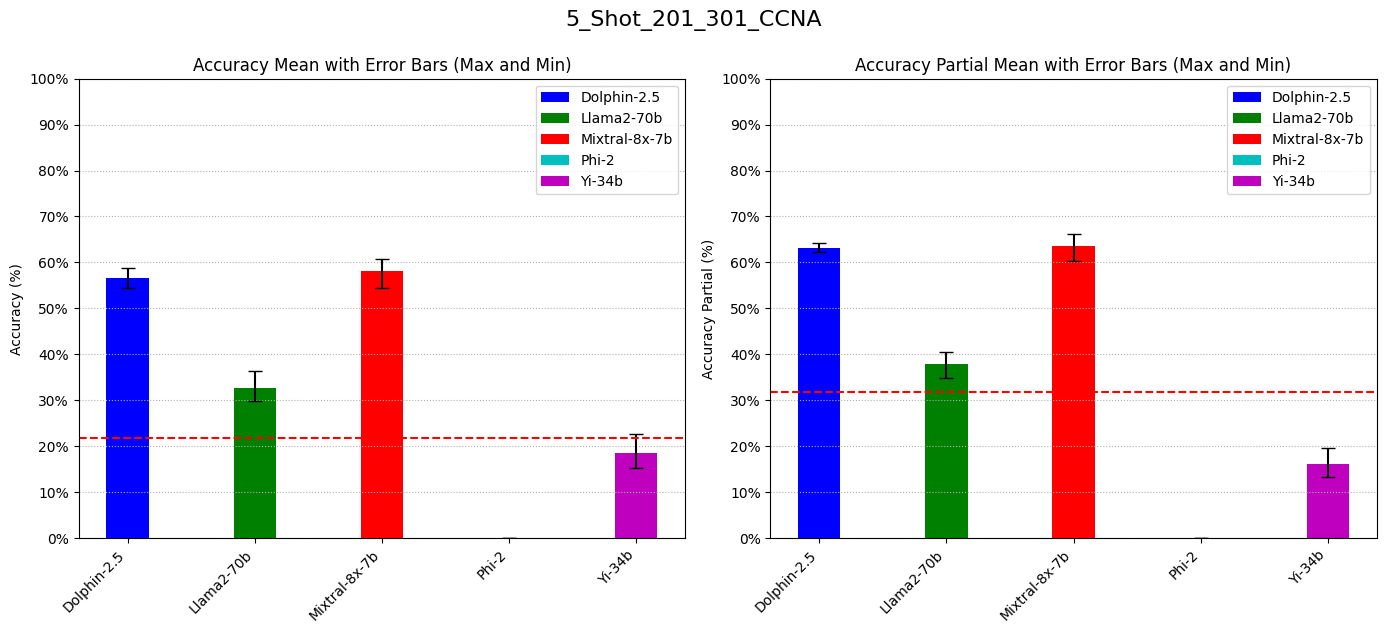

In [49]:
plot_evaluation_CCNA(model_statistics, hline_accuracy=probability, hline_partial=probability+0.1, title=RUN_NAME)